In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dropout,BatchNormalization,Activation,ZeroPadding2D,AveragePooling2D,MaxPooling2D,Add,AveragePooling2D,Flatten,Dense,Input
from keras.utils import to_categorical
from keras.initializers import glorot_uniform,glorot_normal
from keras.optimizers import Adadelta
from keras import backend as k
from keras.engine.input_layer import Input
from random import shuffle
from keras.models import Model, load_model

#Set to mini batch
batch_size = 128
#the number of classes we want to classify 0 --- 9
num_classes =2

DATA_DIR = 'PetImages'

IMAGE_ROWS, IMAGE_COLUMNS = 100,100

input_shape = (IMAGE_ROWS,IMAGE_COLUMNS,1)


In [3]:
#function to read the data
def create_train_data(load_count):
    num_of_test = 1000
    training_data = []
    # to get the labels right
    for cl_type in ['Dog','Cat']:
        label = [0,0]
        if cl_type == 'Dog':
            label = [1 ,0]
        else :
            label = [0 ,1]
        image_path = os.path.join(DATA_DIR,cl_type)
        #the number of items from each class
        num_of_test= load_count
        for img in os.listdir(image_path):
            if num_of_test  == 0 :
                break
            path = os.path.join(image_path,img)
            image =cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if not image is None:
                image_resize = cv2.resize(image,(IMAGE_ROWS, IMAGE_COLUMNS))
                training_data.append([np.array(image_resize).astype('float32')/255,np.array(label)])
                num_of_test = num_of_test - 1
    shuffle(training_data)
    
    return training_data
        
        

In [4]:
data = create_train_data(25000)

In [5]:
train = data[:-3000]
test = data[-3000:]

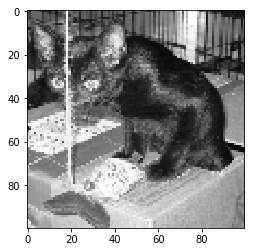

In [28]:
plt.imshow(train[0][0],cmap='Greys_r')

In [7]:
x_train = np.array([i[0] for i in train]).reshape(-1,IMAGE_ROWS,IMAGE_COLUMNS,1)
y_train = np.array([i[1] for i in train])

x_test = np.array([i[0] for i in test]).reshape(-1,IMAGE_ROWS,IMAGE_COLUMNS,1)
y_test = np.array([i[1] for i in test])

print("The shape of the train data " + str(x_train.shape))
print("The shape of the test data " + str(x_test.shape))

The shape of the train data (21946, 100, 100, 1)
The shape of the test data (3000, 100, 100, 1)


In [8]:
def convolutional_block(X,f,filters,stage,block,s = 2):

    #define the name basis
    conv_name_base = "res" + str(stage)+block + "_branch"
    #batch normailization name basis
    bn_name_base = "bn" + str(stage)+block+ "_branch"
    #get the filters
    f1,f2,f3 = filters
    #save the shortcut value
    x_shortcut = X
    #creat the main path
    #create the first layer
    X = Conv2D(f1,kernel_size = (1,1),strides = (s,s),name = conv_name_base +'2a',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2a')(X)
    X = Activation('relu')(X)
    #create the second layer
    X = Conv2D(f2,kernel_size = (f,f),strides = (1,1),name = conv_name_base +'2b',padding= 'same'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2b')(X)
    X = Activation('relu')(X)
    #create the Third layer
    X = Conv2D(f3,kernel_size = (1,1),strides = (1,1),name = conv_name_base +'2c',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2c')(X)
    X = Activation('relu')(X)
    
    #create the shortcut path
    #the filter size is the same as the last one so they could match
    x_shortcut = Conv2D(f3,kernel_size = (1,1),strides = (s,s),name = conv_name_base +'1',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3,name = bn_name_base +'1')(x_shortcut)
    
    X = Add()([X,x_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:

model_input = Input(input_shape)


X = ZeroPadding2D(padding = (3,3))(model_input)

#stage 1
X = Conv2D(filters = 32,kernel_size = (7,7),strides= (2,2),name='conv1'
               ,kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3,name= 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3),strides=(2,2))(X)

X = convolutional_block(X = X,f = 3, filters =[32,32,64],stage = 2,block = 'a',s = 2)

X = Flatten()(X)

X = Dense(num_classes,activation='softmax',name = 'fc' + str(num_classes)
              ,kernel_initializer = glorot_uniform(seed = 0))(X)

model = Model(inputs = model_input,outputs = X,name ='TestNet')


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 106, 106, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 32)   1600        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
#setup the model for training
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adadelta(),
              #We can specify more metrics that we want to monitor
              metrics=['accuracy'])



In [12]:
#train the model
model.fit(x = x_train,y = y_train,
          batch_size = batch_size,
          epochs = 15,
        #this will show is a progress bar put it to 0 so it can remain silent
          verbose =1,
          validation_data = (x_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 21946 samples, validate on 3000 samples
Epoch 1/15
21946/21946 [==============================] - 87s 4ms/step - loss: 2.6161 - acc: 0.5605 - val_loss: 5.4177 - val_acc: 0.5150
Epoch 2/15
21946/21946 [==============================] - 84s 4ms/step - loss: 0.9771 - acc: 0.6406 - val_loss: 0.7840 - val_acc: 0.6187
Epoch 3/15
21946/21946 [==============================] - 82s 4ms/step - loss: 0.6907 - acc: 0.6937 - val_loss: 1.4506 - val_acc: 0.5263
Epoch 4/15
21946/21946 [==============================] - 81s 4ms/step - loss: 0.5908 - acc: 0.7249 - val_loss: 0.6262 - val_acc: 0.7003
Epoch 5/15
21946/21946 [==============================] - 81s 4ms/step - loss: 0.5094 - acc: 0.7600 - val_loss: 1.2014 - val_acc: 0.6003
Epoch 6/15
21946/21946 [==============================] - 81s 4ms/step - loss: 0.4824 - acc: 0.7758 - val_loss: 1.5475 - val_acc: 0.5633
Epoch 7/15
21946/21946 [==============================] - 81s 4ms/step - loss: 0.

In [13]:
#evaluate the model
#for more information run model.metrices_names == > ['loss' , 'acc']
scores = model.evaluate(x = x_test,y=y_test,batch_size = 32,verbose = 1)

3000/3000 [==============================] - 4s 1ms/step


In [27]:
print("The accuracy :")
scores[1]

The accuracy :


0.7046666665077209